<a href="https://colab.research.google.com/github/rmoglin/BIX_F24/blob/main/Moglin_lab9_reward_seeking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Reward seeking

This lab has 3 main components designed to give you an interactive understanding of core reinforcement learning concepts and the $\epsilon$-greedy reinforcement learning algorithm.

Sections:
0. Background on essential reinforcement concepts that we will be engagning with hands-on.
1. Investigating random and $\epsilon$-greedy algorithms in a simple bandit task.
2. Seeing how this sort of policy works in our foraging search.

# New Section

## Background

### The bandit task

In this assignment we study exploration in the very abstract $k$-armed bandit task.
- In this there are $k$ actions to take.
- Each returns a reward $R$, with some probability $p$.
- The reward value is either a 1 or a 0.
- This means the expected value of each arm is simply probability. Nice and simple right?

### Action-value learning

Our agents are really learning, at last. Reinforcement Learning (RL), to be precise.

The reward value $Q$ update rule for all agents (below) and arm is the same:

$ Q \leftarrow Q + \alpha * (R - Q) $ [1]

Where the learning rate on the reward prediction error ($R-Q$) is denoted as $\alpha$, so that the equation above looks nice. If you are not familiar with the idea of a learning rate, it is what it sounds like. A parameter that controls how much each value update matters. This is, over time, the rate at which learning happens.

$Q$ is trying to approximate the average reward value of each arm.

- This kind of difference $(R - Q)$, the reward prediction error (RPE), in Eq [1] is the most typical error signal used for learnin gin RL.
- If you're not sure what it means, consider in your head, what would happen to the value update if $Q$ was bigger than the reward $R$ (and overestimate), or if it was smaller.

Once you have noodled that a bit, as needed, consider how making $\alpha$ bigger or smaller might make $Q$ learning faster, or slower, or more or less volatile. (Learning speed and volatility _often_ go together; an annoying matched set.)

_Note_: We are not going to really play with $\alpha$ here. Just giving you some intuition.

### Basic exploration strategies

Our exploration strategies are a random one, a sequential one, or $\epsilon$-greedy (aka 'e'-greedy).

The $\epsilon$-greedy method is not the best known solution to trading off exploration with exploitation. Then again, it is widely used to this day. It's a place to start.

Our metric is _total reward_. Maximizing that is the goal of all RL, afterall.

## Section - Setup

In [1]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-1nbydw_q
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-1nbydw_q
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=3749e876fbaa5878ef6e4005afe4746c57809af4586f028cdeb4882ffd9e7e2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zgdwele9/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-fg0su_h6
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-fg0su_h6
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

In [24]:
# Import misc
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exploration lib
import explorationlib

# Agents
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import WSLSGrid
from explorationlib.agent import CriticGrid
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import ActorCriticGrid
from explorationlib.agent import DiffusionGrid

# Exp
from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Vis
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

# Env
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values


In [25]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1 - The bandit task

In this section we'll study three explorers getting to know one bandit, with four arms.

**Creating a bandit task**

Let's make a 4-armed bandit and then plot its values. (Expected value is the term used in the literature, so we use it here).

_Note_: The random seed is fixed. If you change the see and run the cell below, some of the reward probabilities will change. The probability of the best arm, the optimal value arm is fixed however. It is set to 0.35, and located at arm 2. Try it! Rerun the cell below with different seeds, a few times, to get a sense of how the non-optimal arms can vary. When you are done, return to the orginal seed value and re-run.

<Axes: xlabel='Arm', ylabel='Expected value'>

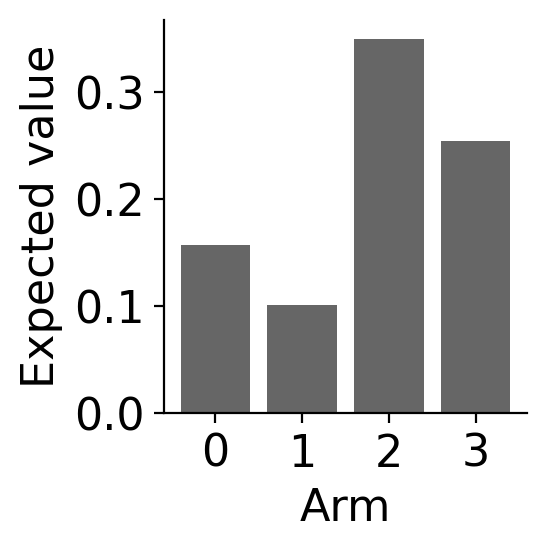

In [26]:
# Shared env params
num_experiments = 1
seed = 5030 # originally 5030

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

---
### Question 1.1

Given the reward probabilities (expected values) in this bandit task, how "easy" or "difficult" do you think this task would be to learn from a simple update rule like we showed above? Why?

__Answer:__

I think it will be easy for this task to learn from a simple update rule because the spread in expected values will allow the algorithm to accumulate evidence more reliability as it can try each arm and quickly find that arm 2 is consistently more rewarding and start favoring it.

**Our three agents**

A word about the code. Our agents this week work in what gets called an ActorCritic desgin. This breaks reinforcement learning algorithms into two parts: the Actor does action selection, and the Critic estimates the value of each action.

Now in normal reinforcement learning, aka not pure exploration, the _Actor_ uses the $Q$ value estimates from the _Critic_ to, in part, make its decisions. Be it explore or exploit. This is indeed the case for how the $\epsilon$-greedy agent, _EpsilonActor_, works.

...But...

The other two agents--_SequentialActor_ and _RandomActor_--don't explore with value. The are both _max entropy_ action systems, who don't care about reward value or learning _at all_. The _ActorCritic_ style is reused because it was easy to implement in _explorationlib_. Don't be misled.

In [27]:
# Creating the three agents

ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    SequentialActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# -
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

Let's run out our three agents on the _env_ (the bandit task we built), and make some plots to visualize what each agent is doing.

In [28]:
num_steps = 12  # Number of choices each agent gets to make, (around 3 per arm)

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/1 [00:00<?, ?it/s]

sequential:   0%|          | 0/1 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/1 [00:00<?, ?it/s]

**Plot action choices**
with time (aka steps).

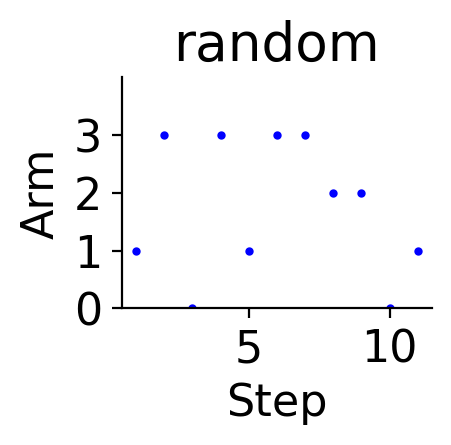

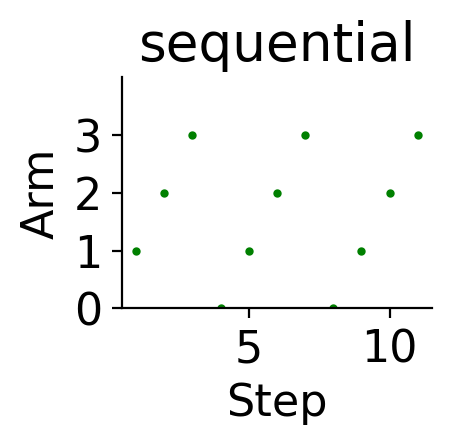

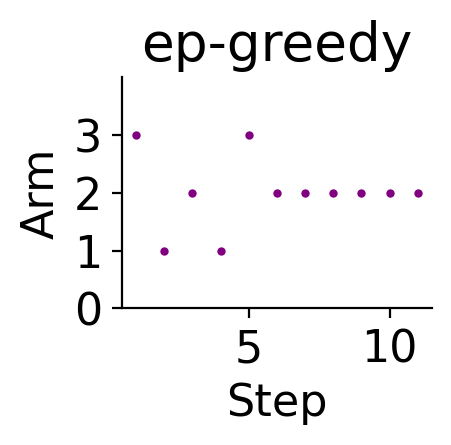

In [29]:
num_experiment = 0
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment),
        num_arms=4,
        s=4,
        title=name,
        color=color,
        figsize=(2, 1.5)
        )

---
### Question 1.2

Describe the coice behavior of each agent type.

__Answer:__

random: like its name, does not settle on one arm and does not show one specific pattern.

sequential: uses a pattern to equally explore each arm, does not settle on one arm.

ep-greedy: qukcly settles on arm 2 as the best choice after exploring arm 1, it shows that it will choose the arm with the most rewards quicly and will not continue to explore.


---
### Question 1.3

Re-run the simulations above a few times. What range of choice patterns does epsilon-greedy agent exhibit? What do you think leads to these patterns?

__Answer:__

it always eventually settls for arm 2 - the arm with the highest expected value. However, sometimes it explores other arms first, one pattern had it bouncing between arms 2 and 3, which makes sense as it is the arm with the second highest reward before settling for 2. Other times it just tries one other arm and just settles for 2. These patterns occur becuase arm 2 has the highest expected value and the agent starts with default value estimates which changes after each step, so if the agent discovers early on that 2 yeilds high value it will stick with it. However, due to chance if it yeielded a lower value, the agent will likly try other options. Additionally the higher the e value the more likley the agent will try other arms, lower e will reduce exploraiton leading to faster converagance on what it perceives to be the best arm.

---
### Question 1.4

Now change the ϵ value for the ϵ-greedy agent to $0.01$ and re-run the simulations a few times. How does the behavior of this agent change? What does this tell you about the utility of greediness in this particular form of the bandit task?

__Answer:__

in some sims it settles on arm 2 much faster, some simulations on ethe first try. However, some simualtions it settles on a differnt arm very quickly showing that it redcues explorations converaging on what it percieves to be the highest value arm. In this task the greediness which correlates to low exploration can be beneifcial if it corrertly discovers the highest yeilding arm early. However, it can be detrimental if the intial choices are misleading (ie. chance of seeing a low value for 2) as the agent will not explore futher to correct early misjudgements.

**Histograms of action probability (aka arm choice).**

_Fun fact_: The flatter these plots are, the closer they are to what is called _maximum entropy_ exploration behavior.

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

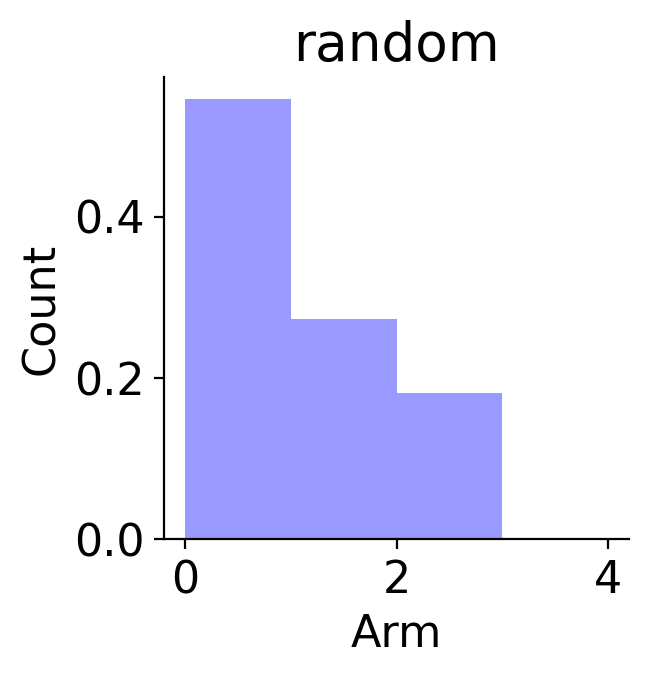

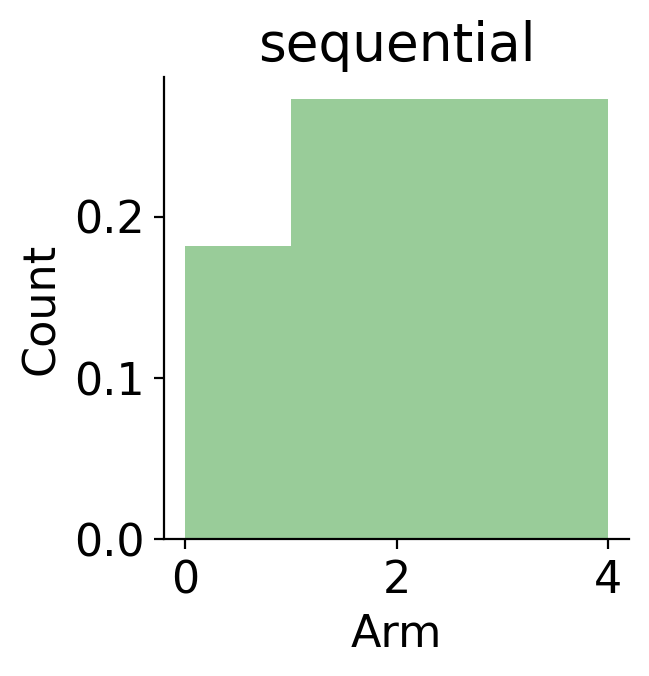

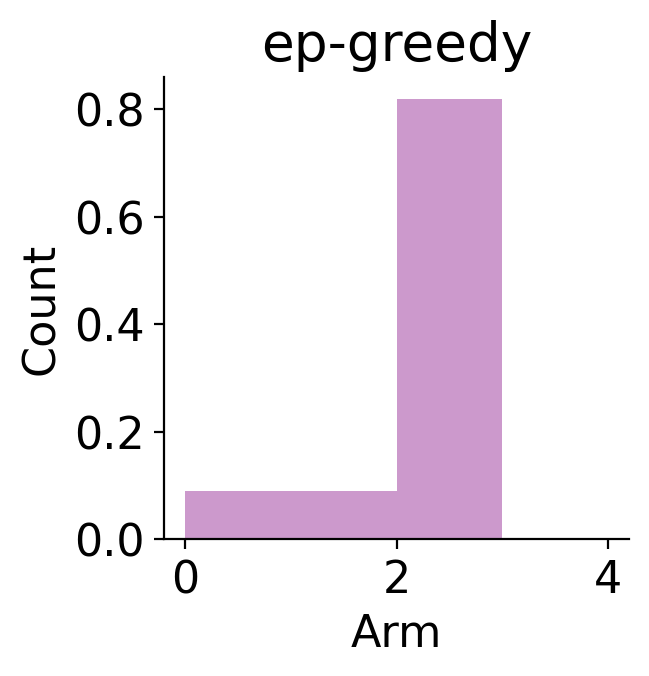

In [8]:
num_experiment = 0
ax = None
for name, res, color in zip(names, results, colors):
    ent = np.round(np.mean(action_entropy(res)), 2)
    plot_bandit_hist(
        select_exp(res, num_experiment),
        bins=list(range(0, 5)),
        title=f"{name}", # (ent {ent})",
        alpha=0.4,
        color=color,
        figsize=(3, 3),
        ax=ax
        )

## Section 2 - Investigating the epsilon-greedy algorithm

**Meet our dilemma**
I've been learning Q-value estimates.
* Should I explore (keep sampling the options to get more data points to update Q-value estimates)?
* Should I exploit (choose the action whose Q value estimate is currently the greatest)?

*A simple strategy:*

....I'll flip a weight coin,

...who's weight has a name. It's $\epsilon$!

The smaller $\epsilon$ is, the less likely the coin flip comes up "EXPLORE''. The more likely it comes up on the "EXPLOIT" side. If one chooses the exploit side, one is being greedy, right? The bigger $\epsilon$ the more likely the coin will say "EXPLORE ''. Etc.

Let's play with $\epsilon$-greedy, on our base case bandit task.

---
### Question 2.1

We will run three differnt epsilon-greedy agents, each with a different epsilon value (0.05, 0.5, and 0.95). What do you expect each agent's stepwise behavior to "look like"? Why?

__Answer:__

0.05: agent will only explore only 5% of the time and exploit best known reward arm 95% of the time. Leading for quick settling on the arm it intially identifies as best. It will very rarely explore arm choices beyond maybe 1 or 2. The low e value makes agent very greedy (very exploitative not exploratiive)

0.5: agent will explore 50% of the time, exploit 50%. behavior will be very variable and sometimes it will lock in early others it will keep exploring. It will create a reasonaby accurate estimate of each arm's expected value since it spends a lot of time exploring and settling due to its e value

0.95: agent will explore 95% of tiem time. This will result in constant explroation and will be highly variable while it creates estimated values. It will not settle on a single choice until much later, if at all and might even appear random.

In [31]:
num_steps = 4 * 100
epsilons = [0.05, 0.5, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["mediumpurple", "mediumorchid", "mediumvioletred"]

# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

Example behavior visualizations below. Change _num experiment_ to see more examples (0, 99).

_Note_: in every experiment we run in this lab, the optimal value arm is _always_ arm 2.

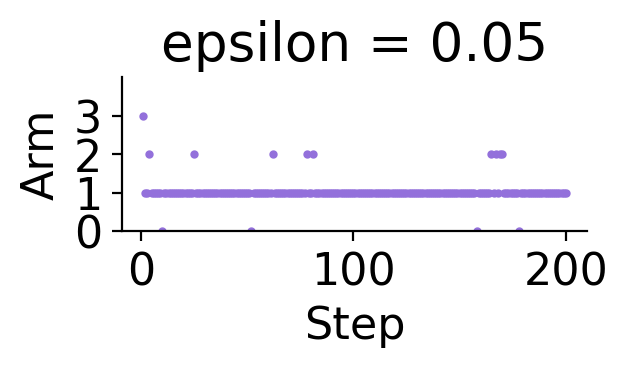

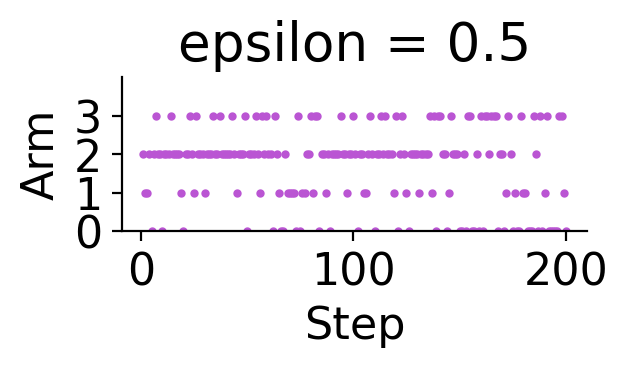

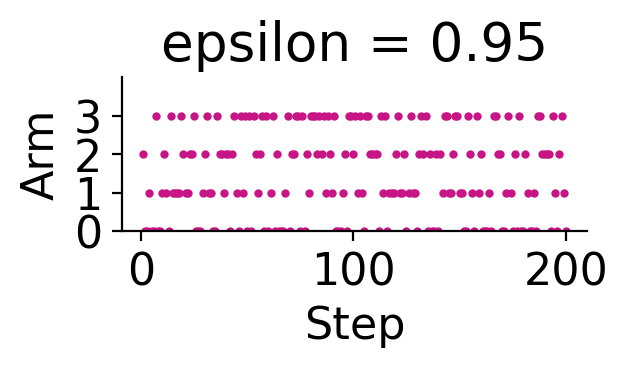

In [32]:
num_experiment = 50
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment),
        max_steps=200,
        s=4,
        title="epsilon = " + name,
        color=color,
        figsize=(3, 1)
        )

---
### Question 2.2

Did the behavior match what you expected? If not, describe the actual behavior and explain what you think is behind it.

__Answer:__

Yes, it matches what I expected.

---
### Question 2.3

Re-run the stepwise choice behavior visualization at different `num_experiment` settings to view what happens in different experiments. Find a case when epsilon=0.05 agent didn't select the best arm (Arm 2) very much. How do you think this happened?

__Answer:__

This might have happended because the agent had many opportunities to explore and the exploration phase occurs too often, the agent might not have consistently selected arm 2.

---
### Question 2.4

We will visualize the average total reward for each agent next. Which agent do you think will collect the most reward and which one the least? Why?

__Answer:__

E-0.05 will have the highest total reward becuase it settles on an option faster and from previous simulations, it almost always selected arm 2 quickly and sometimes arm 3 (which also had high reward), leading to accumuatling rewards quicly. I think E-.95 will have the least rewards becuase it will spend most of its time randomly exploring resutling in it chooseing arms that yeild lower rewards despite knowing that arm 2 yeilds high rewards.

**Visualize total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

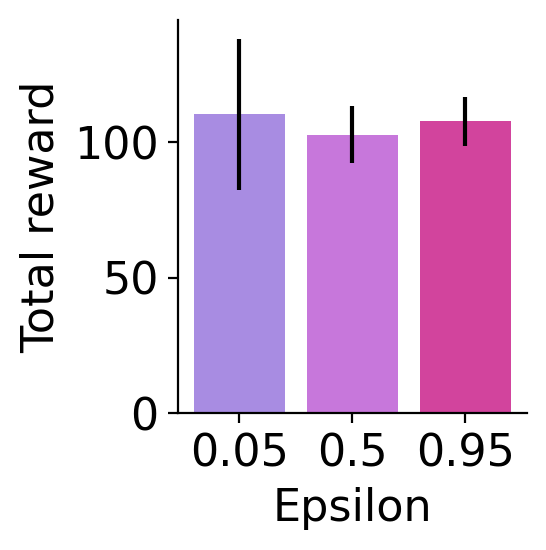

In [11]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

---
### Question 2.6

Were your predictions in questions 2.4 and 2.5 correct? If not, describe the actual results and explain what you think led to them.

__Answer:__

my predicitions for highest reward were correct. 0.5 scored the wrose with 0.95 being second best. However, 0.5 might have scored worse than 0.95 becuase it might have settled for lower reward arms and fared worse than randomly selecting.

**Visualizing a histogram of average choice reward across experiments**

To get average choice reward for each experiment, we divide the total reward for the experiment by the number of steps (choices) taken to collect that total reward.

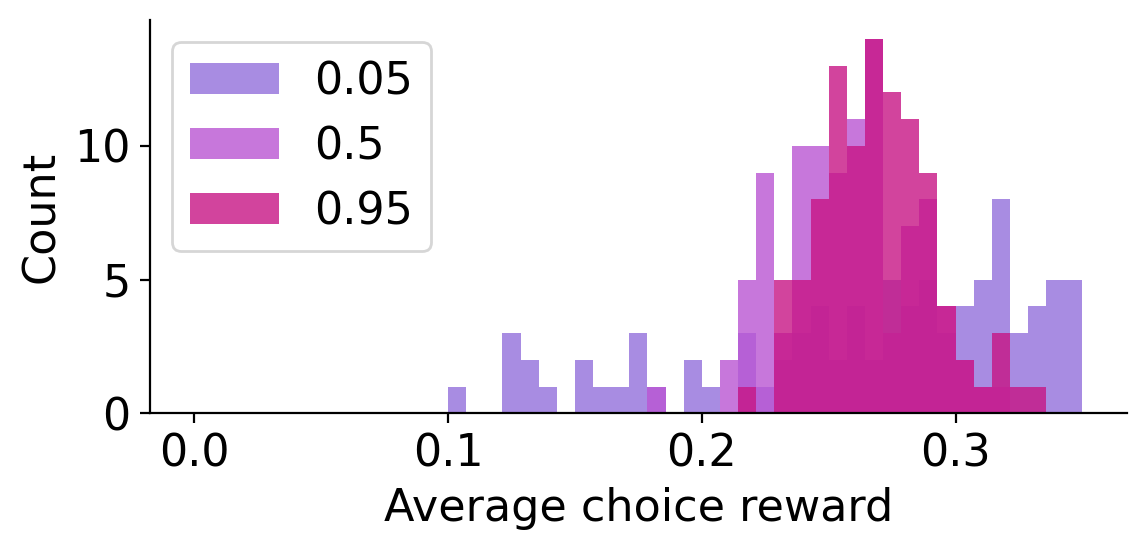

In [12]:
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(np.array(s)/num_steps, label=name, color=c, alpha=0.8, bins=np.linspace(0, 0.35, 50))
    plt.legend()
    plt.xlabel("Average choice reward")
    plt.ylabel("Count")
    plt.tight_layout()
    sns.despine()

---
### Question 2.7

If instead of 400 steps in each experiment we let each agent run to near infinity, what would the above histogram look like and why?

__Answer:__

0.95 and 0.5 would probably follow the normal distrubtion more and 0.05 might have a larger spke at 0.3.

---
### Question 2.8

Based on what you've seen here today, if you were to follow an ϵ-greedy policy for choices in your own life, what value of ϵ would you choose? Why?

__Answer:__

I would choose 0.05 because it had the highest overall reward despite sometimes choosing the wrong path.

## Section 3 - Reward driven search

Now we are going to create an agent in our foraging environment that implements reward driven search using the exact same approaches we have described above. We shall call this process _rewardtaxis_.

This is a Q-learning agent that uses softmax exploration policiy, as opposed to an $\epsilon$-greedy policy. It does not use teh scent, but wanders until it finds a target, notes the value (reward) of each position on the grid and makes it immediate choices based onthe value of the four possible actions (up, down, left, right) from the current position.

We start by setting up our patchy environment.

In [13]:
# Noise and delete
p_scent = 0.1
noise_sigma = 2.0

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838
num_targets = 20 # with 80 agents are more competitive!

# Environment parameters
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)


# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1

# Targets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

**Getting to know you, RL**

For this demo we will set up two agents:

- Rando: random walker just like we have been using before.
- RL: An agent that uses reinforcement learning (Q-learning) to track a target.

We are going to give each of our agents 99 tries at the _same_ environment. We want to see how repeated exposure to the same environment will improve performance in our agents.

In [14]:
# RL
possible_actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
critic = CriticGrid(default_value=0.5)
actor = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)
rl = ActorCriticGrid(actor, critic, lr=0.1, gamma=0.1)

# Rando

diff = DiffusionGrid()
diff.seed(seed_value)

# !
rl_exp = experiment(
    f"RL",
    rl,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

RL:   0%|          | 0/100 [00:00<?, ?it/s]

rand:   0%|          | 0/100 [00:00<?, ?it/s]

To start, let's just look at one example of the movement of our random agent, for comparison with the cells below

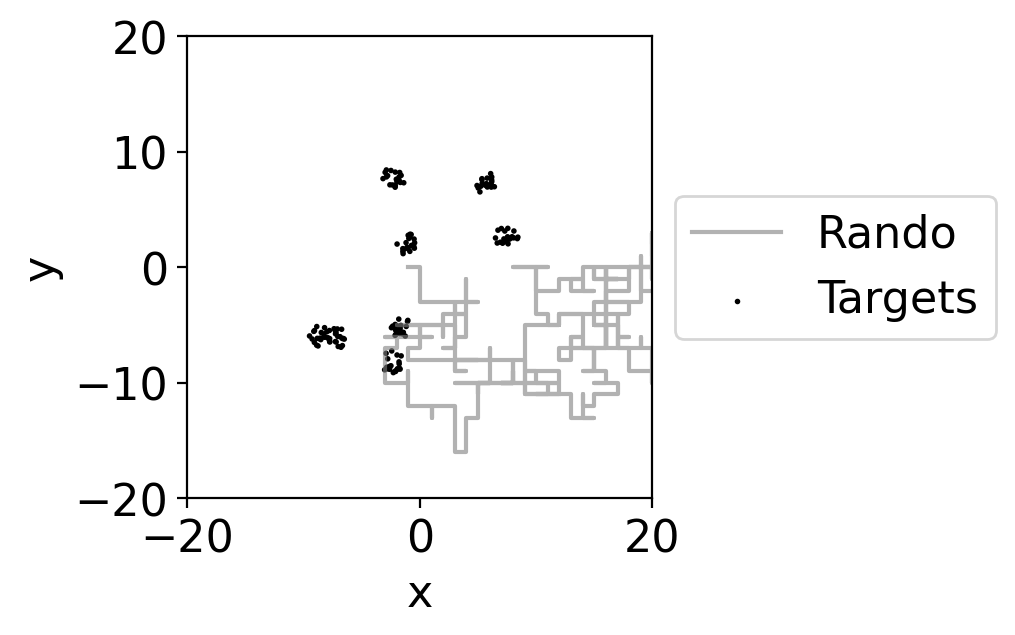

In [15]:
plot_boundary = (20, 20)

# -
num_experiment = 99
ax = None
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label=f"Rando",
    color="grey",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

So our little friend is doing just fine in this random case.

Now let's look at our our RL agent progresses over runs of the experiment. We'll look at at three time points (N=0, early; N=50, middle; N=99, late)

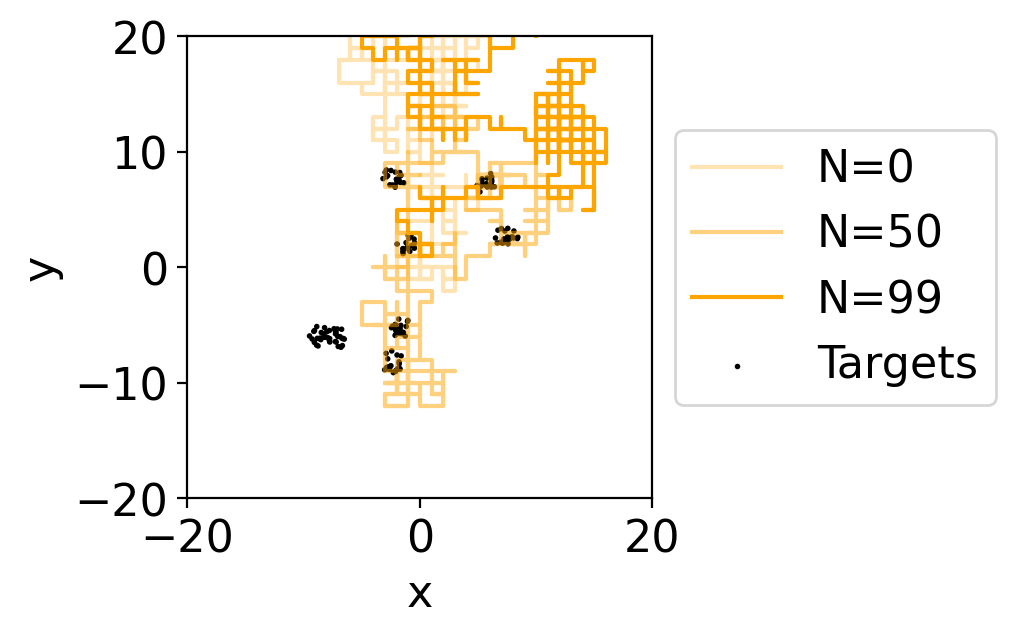

In [16]:
plot_boundary = (20, 20)

# -
num_experiment = 0
ax = None
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=0.3,
    ax=ax,
)
num_experiment = 50
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=0.5,
    ax=ax,
)
num_experiment = 99
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=1,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Notice how much more structured the search becomes areound the patches with more practice. Not great, but getting there.

**Reward value, in time**

Now let's look at the value ($Q$-value in this case) of the optimal value (i.e., $max(Q(a))$) across time for each of these three stages of learning.

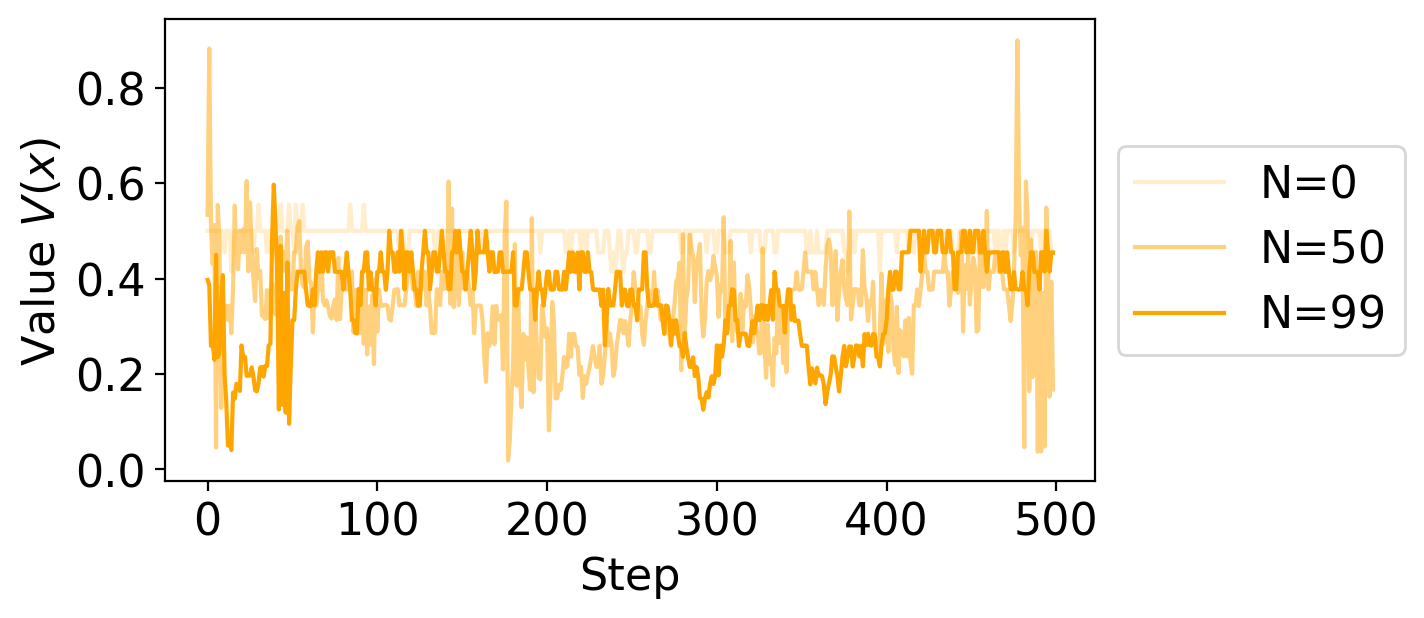

In [17]:
fig = plt.figure(figsize=(6, 3))
plt.plot(rl_exp[0]["agent_reward_value"], label="N=0", color="orange", alpha=0.2)
plt.plot(rl_exp[50]["agent_reward_value"], label="N=50", color="orange", alpha=0.5)
plt.plot(rl_exp[99]["agent_reward_value"], label="N=99", color="orange", alpha=1)
plt.ylabel("Value $V(x)$")
plt.xlabel("Step")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

---
### Question 3.1

What do you see in this behavior of the RL agent over time?

__Answer:__

It seems to average around 0.4 value wise and over time it mostly sticks to medium values and moves away quicly from either extremely high values or low values which is intresting. It did not seem to consistently trend higher over time.

**Looking across simulations**

Now let's plot our metrics and see how the two agents did.

**Death**

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

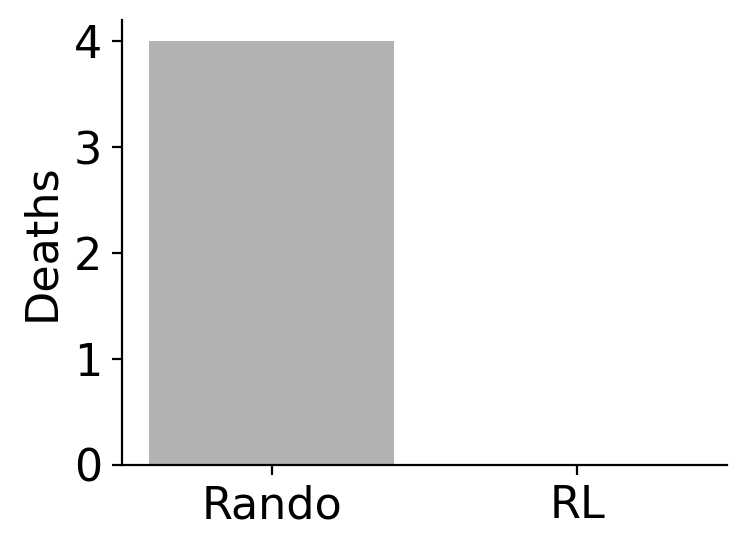

In [18]:
# Results
results = [rand_exp, rl_exp]
names = ["Rando", "RL"]
colors = ["grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

**Total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

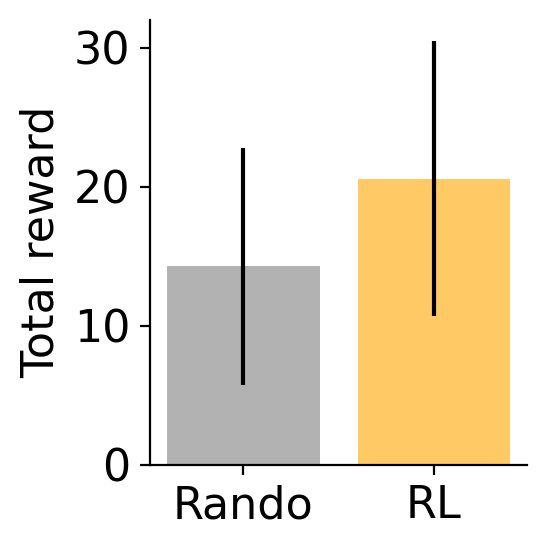

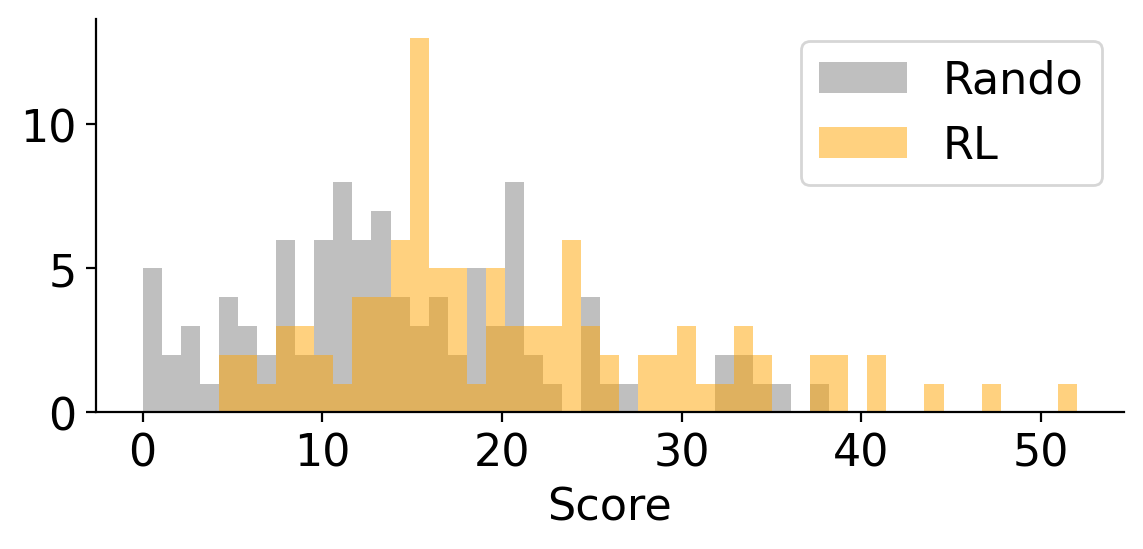

In [19]:
# Results
results = [rand_exp, rl_exp]
names = ["Rando", "RL"]
colors = ["grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 3.2

How does the performance of the RL agent compare, across all performance metrics, to the random agent? Is this a fair comparison? Why or why not?

__Answer:__

The RL agent did better across all performce metrics compared to the rando with 0 deaths and about 5 average higher rewards. Given that the environemtn is the same for both agents, it is a somewaht fair comparision however, given that we used a patch environemnt it gives an advangte to the RL model becuase it will discover where the patches are and stay in them over time whereas the random model will continue randomly explore. If we used random palcement of targets without pathces, maybe they would have preformed differently.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*